In [162]:
import numpy # matrices and multi - dimensional arrays , linear algebra
import sklearn # machine learning
import matplotlib # plotting

In [163]:
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


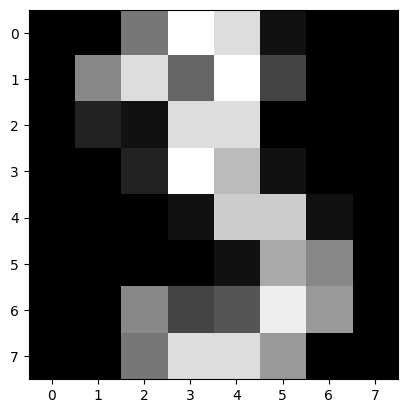

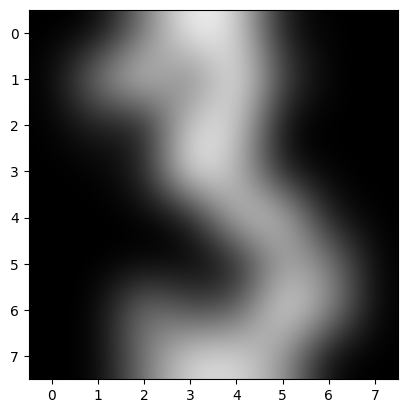

In [164]:
import numpy as np
import matplotlib.pyplot as plt

img = images[3]

assert 2 == len(img.shape)

plt.figure()
plt.gray()
plt.imshow(img, interpolation='nearest')
plt.show()
plt.imshow(img, interpolation='bicubic') 
plt.show()


In [165]:
filter_indices = np.where(np.isin(target, [3, 9]))

# Use the filtered indices to get the corresponding elements from data, images, and target
data = data[filter_indices]
images = images[filter_indices]
target = target[filter_indices]

In [166]:
from sklearn import model_selection

X_all = data
y_all = target
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, target, test_size=0.4, random_state=0)

In [167]:
def features2d(x):
    features = np.zeros((x.shape[0], 2))
    for i in range(x.shape[0]):
        features[i, 0] = x[i, 10] + x[i, 18] + x[i, 26]
        features[i, 1] = x[i, 26] + x[i, 27] + x[i, 28]
       
    return features

features_all = features2d(X_all)
features_train = features2d(X_train)
features_test = features2d(X_test)

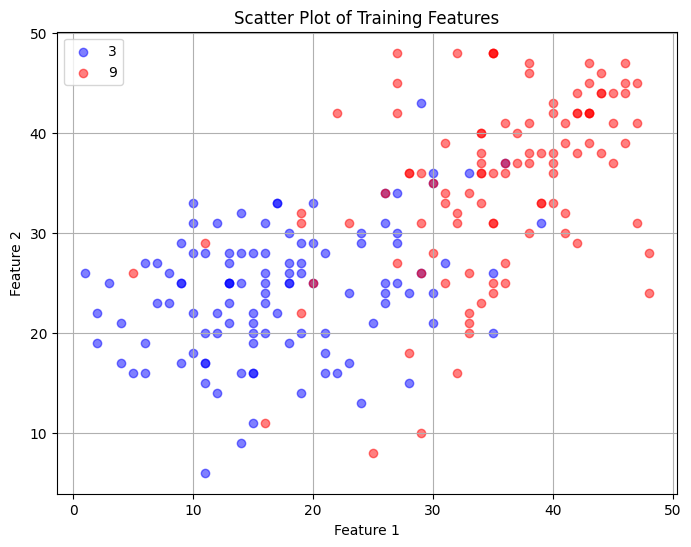

In [168]:
def plot_points_with_colors(points, labels):
    # Extract x and y coordinates
    x_coords = points[:, 0]
    y_coords = points[:, 1]
    
    # Create a mask for points labeled as 3 and 9
    mask_3 = (labels == 3)
    mask_9 = (labels == 9)

    # Create scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x_coords[mask_3], y_coords[mask_3], marker='o', color='blue', label='3', alpha=0.5)
    plt.scatter(x_coords[mask_9], y_coords[mask_9], marker='o', color='red', label='9', alpha=0.5)
    plt.title('Scatter Plot of Training Features')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_points_with_colors(features_train, y_train)

In [169]:
def nearest_mean(X_train, y_train, X_test):

    #Compute the mean of each class
    mean_3 = np.mean(X_train[y_train == 3], axis=0)
    mean_9 = np.mean(X_train[y_train == 9], axis=0)
    
    # Compute the Euclidean distance from each test point to the mean of each class
    distance_3 = np.linalg.norm(X_test - mean_3, axis=1)
    distance_9 = np.linalg.norm(X_test - mean_9, axis=1)
    
    # Classify test points based on the minimum distance
    test_labels = np.where(distance_3 < distance_9, -1, 1)
    
    return test_labels, mean_3, mean_9

def calculate_error_rate(predicted_labels, true_labels):
    total_sample = len(true_labels)
    fn = 0
    fp = 0
    for i in range(total_sample):
        if predicted_labels[i] != -1 and true_labels[i] == 3:
            fn += 1
        elif predicted_labels[i] != 1 and true_labels[i] == 9:
            fp += 1
    
    return (fp + fn) / total_sample  

predicted_labels_mean, mean_3, mean_9 = nearest_mean(features_train, y_train, features_test)
error_rate_mean = calculate_error_rate(predicted_labels_mean, y_test)
print(f"Error Rate Nearest Mean: {error_rate_mean*100:.2f}%")


Error Rate Nearest Mean: 11.64%


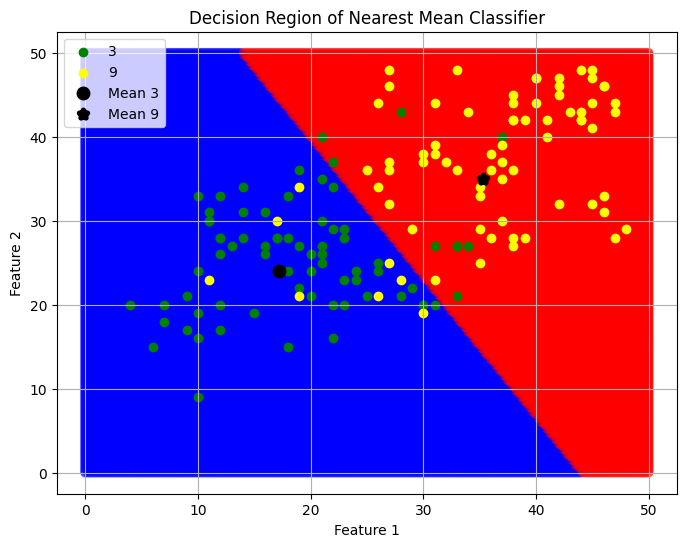

In [170]:
# Create a 200x200 grid
x_min, x_max = 0, 50
y_min, y_max = 0, 50
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

grid_values = np.c_[xx.ravel(), yy.ravel()]

distance_3 = np.linalg.norm(grid_values - mean_3, axis=1)
distance_9 = np.linalg.norm(grid_values - mean_9, axis=1)
    
# Classify test points based on the minimum distance
decision_region = np.where(distance_3 < distance_9, -1, 1)

# Extract x and y coordinates from grid_values
x_coords = grid_values[:, 0]
y_coords = grid_values[:, 1]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, c=np.where(decision_region == -1, 'blue', 'red'), marker='o', alpha=0.5)
plt.scatter(features_test[y_test == 3, 0], features_test[y_test == 3, 1], c='green', marker='o', label='3')
plt.scatter(features_test[y_test == 9, 0], features_test[y_test == 9, 1], c='yellow', marker='o', label='9')
plt.scatter(mean_3[0], mean_3[1], c='black', marker='o', label='Mean 3', linewidth=4)
plt.scatter(mean_9[0], mean_9[1], c='black', marker='*', label='Mean 9', linewidth=4)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Region of Nearest Mean Classifier')
plt.legend()
plt.grid(True)
plt.show()

In [171]:
def fit_lda(X_train, y_train):
    # Compute the mean of each class
    mu_3 = np.mean(X_train[y_train == 3], axis=0)
    mu_9 = np.mean(X_train[y_train == 9], axis=0)
    mu = np.array([mu_3, mu_9])
    
    # Compute the covariance matrix
    cov = 0
    for x, y in zip(X_train, y_train):
        if y == 3:
            x_i = x - mu_3
        else:    
            x_i = x - mu_9
        cov += np.outer(x_i, np.transpose(x_i))

    covmat = cov/len(y_train)
    # Compute the prior probability of each class
    p = np.array([np.sum(y_train == 3) / len(y_train), np.sum(y_train == 9) / len(y_train)])

    return mu, covmat, p

def filter_pixels(X_train, X_test, var=0.001):
    pixel_variances = np.var(X_train, axis=0)
    # Find pixels with variance smaller than 0.001
    dead_pixels_mask = pixel_variances < var
    # Filter out dead pixels
    X_train_filtered = X_train[:, ~dead_pixels_mask]
    X_test_filtered = X_test[:, ~dead_pixels_mask]
    return X_train_filtered, X_test_filtered

X_train_filtered, X_test_filtered = filter_pixels(X_train, X_test)
feature_mu, feature_covmat, feature_p = fit_lda(features_train, y_train)
var_mu, var_covmat, var_p = fit_lda(X_train_filtered, y_train)

In [172]:
def predict_lda(mu, covmat, p, test_features):
    # Compute the inverse of the covariance matrix
    covmat_inv = np.linalg.inv(covmat)

    beta = np.dot(covmat_inv, np.transpose(mu[1] - mu[0]))
    b = -0.5 * np.dot((mu[0] + mu[1]), beta) + np.log(p[1] / p[0])
    # Compute decision function scores
    decision_scores = np.dot(test_features, beta) + b
    # Classify test points based on the decision function scores
    predicted_labels = np.sign(decision_scores)
    
    return predicted_labels

predicted_labels_feature_test = predict_lda(feature_mu, feature_covmat, feature_p, features_test)   
predicted_labels_var_test = predict_lda(var_mu, var_covmat, var_p, X_test_filtered)
predicted_labels_feature_train = predict_lda(feature_mu, feature_covmat, feature_p, features_train)   
predicted_labels_var_train = predict_lda(var_mu, var_covmat, var_p, X_train_filtered)

error_rate_lda_feature_test = calculate_error_rate(predicted_labels_feature_test, y_test)
error_rate_lda_var_test = calculate_error_rate(predicted_labels_var_test, y_test)
error_rate_lda_feature_train = calculate_error_rate(predicted_labels_feature_train, y_train)
error_rate_lda_var_train = calculate_error_rate(predicted_labels_var_train, y_train)

print(f"Error Rate LDA Feature Test: {error_rate_lda_feature_test*100:.2f}%")
print(f"Error Rate LDA Variance Test: {error_rate_lda_var_test*100:.2f}%")
print(f"Error Rate LDA Feature Train: {error_rate_lda_feature_train*100:.2f}%")
print(f"Error Rate LDA Variance Train: {error_rate_lda_var_train*100:.2f}%")

Error Rate LDA Feature Test: 11.64%
Error Rate LDA Variance Test: 1.37%
Error Rate LDA Feature Train: 13.36%
Error Rate LDA Variance Train: 0.46%


These are the distinct error rates obtained from our implementation of LDA. The four values represent various combinations of LDA error rates: one with our handcrafted features and another with pixel data exhibiting sufficiently high variance, each tested using our separate test and train datasets. This data suggests that our handcrafted features are not very good in differentiating between 3's and 9's. Another noticeable characteristic is that the Error rate for our features is higher for the Train data then it is for the Test data. This is normally not the case but it could be a coincidence.

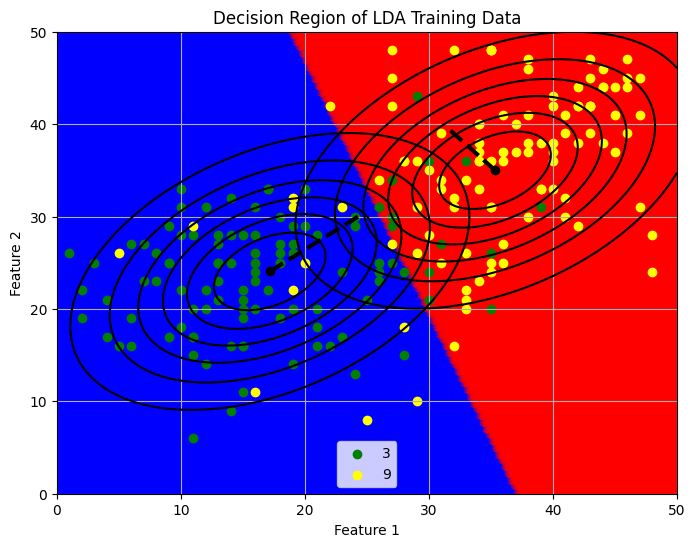

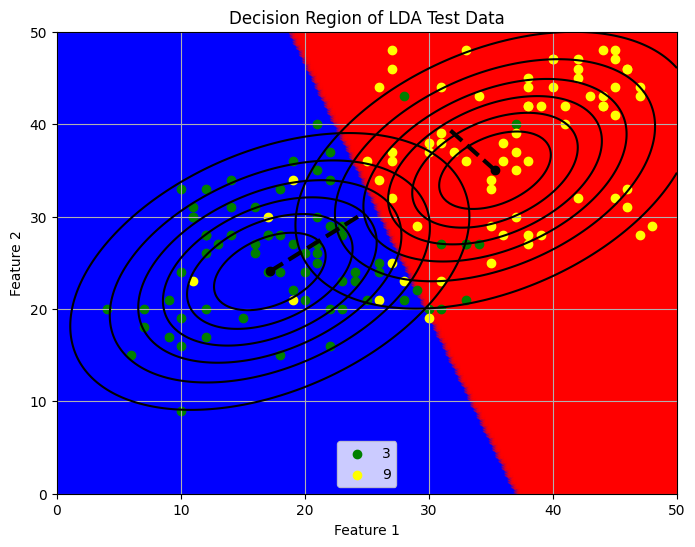

In [173]:
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal

features = [features_train, features_test]
y = [y_train, y_test]
titles = ["Decision Region of LDA Training Data", "Decision Region of LDA Test Data"]
for i in range(len(features)):

    # Create a 200x200 grid
    x_min, x_max = 0, 50
    y_min, y_max = 0, 50
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

    grid_values = np.c_[xx.ravel(), yy.ravel()]

    # Classify test points based on the decision boundary
    decision_region = predict_lda(feature_mu, feature_covmat, feature_p, grid_values) 

    # Extract x and y coordinates from grid_values
    x_coords = grid_values[:, 0]
    y_coords = grid_values[:, 1]

    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x_coords, y_coords, c=np.where(decision_region == -1, 'blue', 'red'), marker='o', alpha=0.5)

    plt.scatter(features[i][y[i] == 3, 0], features[i][y[i] == 3, 1], c='green', marker='o', label='3')
    plt.scatter(features[i][y[i] == 9, 0], features[i][y[i] == 9, 1], c='yellow', marker='o', label='9')


    eigenvalues, eigenvectors = np.linalg.eig(feature_covmat)

    # Plot each Gaussian distribution
    for j in range(len(feature_mu)):
        # Compute PDF values for the grid points
        pdf_values = multivariate_normal.pdf(grid_values, mean=feature_mu[j], cov=feature_covmat)

        # Reshape PDF values to match grid shape
        pdf_values = pdf_values.reshape(xx.shape)

        # Plot isocontours (ellipses)
        plt.contour(xx, yy, pdf_values, colors='k')

        # Plot mean of the Gaussian distribution
        plt.plot(feature_mu[j][0], feature_mu[j][1], 'ko')

        # Compute standard deviations along each principal component (square roots of eigenvalues)
        std_devs = np.sqrt(eigenvalues)

        # Get principal cluster axes (eigenvectors)
        principal_axes = eigenvectors.T[j] * std_devs[j]  # Scale eigenvectors by standard deviations

        # Plot principal cluster axes
        plt.plot([feature_mu[j][0], feature_mu[j][0] + principal_axes[0]], [feature_mu[j][1], feature_mu[j][1] + principal_axes[1]], 'k--', linewidth=3)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(titles[i])
    plt.legend()
    plt.grid(True)
    plt.show()

Although the points for the LDA with the Training data look like they are closer to the mean of the gaussian distribution, the actual error rate is higher for the LDA with the Training data which is unusual.

In [174]:
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

estimator = LinearDiscriminantAnalysis()


scores = cross_val_score(estimator, X_all, y_all, cv=10)
print(scores.mean())

0.9779279279279278


The sklearn implementation of the LDA reaches even for all 64 pixels used as feature a pretty high accuracy of 0.978. This, as well as the different Error Rates from our implementation would suggest that our features are not very well selected.

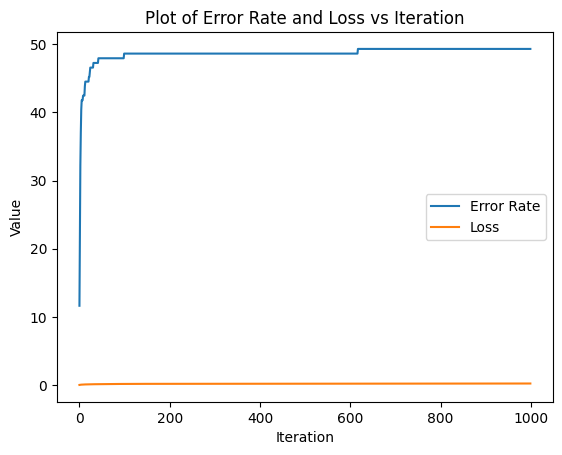

In [175]:
def calculate_delta_loss(X, y, beta, b, _lambda):
    sum_b = 0
    sum_beta = 0
    for i in range(len(y)):
            if y[i] * (np.dot(X[i], beta) + b) < 1:
                sum_beta -= y[i] * np.transpose(X[i])
                sum_b -= y[i]
    delta_b = (_lambda / len(y)) * sum_b
    delta_beta = beta + (_lambda / len(y)) * sum_beta

    return delta_beta, delta_b

def fit_svm(training_features, training_labels, _lambda, beta, b, tau):
    _sum = 0
    for i in range(len(training_labels)):
        _sum += np.maximum(1 - training_labels[i] * (np.dot(training_features[i], beta)) + b, 0)

    loss = 0.5 * np.dot(np.transpose(beta), beta) + (_lambda / len(training_labels)) * _sum

    delta_beta, delta_b = calculate_delta_loss(training_features, training_labels, beta, b, _lambda)
    beta -= tau * delta_beta
    b -= tau * delta_b

    return loss, beta, b

def predict_svm(test_features, beta, b):
    return np.sign(np.dot(test_features, beta) + b)


tau = 0.0001
_lambda = 10
#beta = np.random.normal(0, 1, training_features.shape[1])
#b = 0
beta = np.array([0.24034121, 0.08780151])
b = -8.948143239056721

epochs = 1000
error_rate_list = []
loss_list = []

for i in range(epochs):
    if i == 900:
        tau /= 10
    predicted_labels = predict_svm(features_test, beta, b)
    error_rate = calculate_error_rate(predicted_labels, y_test)
    loss, beta, b = fit_svm(features_train, y_train, _lambda, beta, b, tau)
    error_rate_list.append(error_rate*100)
    loss_list.append(loss)

plt.plot(range(epochs), error_rate_list, label='Error Rate')
plt.plot(range(epochs), loss_list, label='Loss')

plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Plot of Error Rate and Loss vs Iteration')
plt.legend()
plt.show()



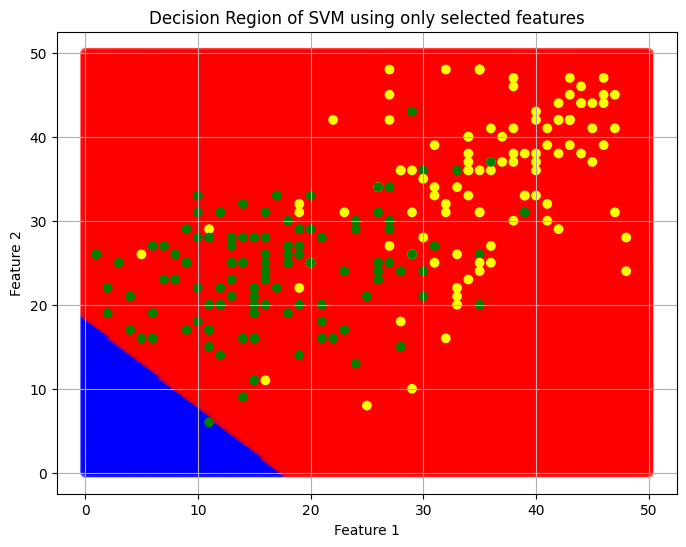

In [176]:
# Create a 200x200 grid
x_min, x_max = 0, 50
y_min, y_max = 0, 50
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

grid_values = np.c_[xx.ravel(), yy.ravel()]

# Classify test points based on the decision boundary
decision_region = predict_svm(grid_values, beta, b)

# Extract x and y coordinates from grid_values
x_coords = grid_values[:, 0]
y_coords = grid_values[:, 1]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, c=np.where(decision_region == -1, 'blue', 'red'), marker='o', alpha=0.5)
plt.scatter(features_train[:, 0], features_train[:, 1], c=np.where(y_train == 3, 'green', 'yellow'), marker='o', label='Training Data')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Region of SVM using only selected features')
plt.grid(True)
plt.show()

Somehow, even if we choose good initial values  for beta and b that we have from the LDA, the SVM doesn't perform as expected. No matter how the hyperparameters are changed, the error rate always seems to converge to about 50%. In the Decision Region it is good visible that the reason for the ca. 50% error rate is that the decision boundary got moved so far to one side that almost every data point is on the same side. In comparison the sklearn implementation of the SVM works very well with an average accuracy of 0.986. This would suggest that either we did something wrong with the hyperparameters or our implementation is incorrect.

In [177]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

estimator = SVC(kernel='linear', C=1.0, gamma='auto')
scores = cross_val_score(estimator, X_all, y_all, cv=10) 

print(scores.mean())

0.9862612612612611
